# Import necessary libraries



In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score



# Load datasets


In [21]:
customers = pd.read_csv(R'C:\Users\anush\Downloads\Customers.csv')
products = pd.read_csv(R"C:\Users\anush\Downloads\Products.csv")
transactions = pd.read_csv(R"C:\Users\anush\Downloads\Transactions.csv")



# Merge data


In [22]:
data = transactions.merge(products, on='ProductID', how='left')
data = data.merge(customers, on='CustomerID', how='left')



# Handle duplicate price columns


In [23]:
data['Price'] = data['Price_x']  # Use Price_x (from Transactions) or Price_y (from Products)

# Feature engineering for clustering

In [24]:
# 1. Aggregate transaction data per customer
customer_data = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',        # Total spending
    'TransactionID': 'count',  # Number of transactions
    'Quantity': 'sum',         # Total quantity purchased
    'Price': 'mean'            # Average price of items bought
}).reset_index()

# 2. Add customer profile information
customer_profile = customers[['CustomerID', 'Region']]
final_data = customer_data.merge(customer_profile, on='CustomerID', how='left')

# Enoding, Clustering and Visualization

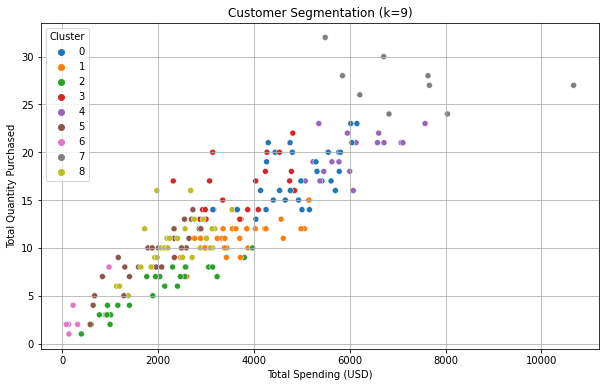

Optimal number of clusters: 9
Davies-Bouldin Index: 1.0846


In [25]:
# Encoding categorical data (Region)
final_data['Region'] = final_data['Region'].astype('category').cat.codes

# Prepare data for clustering
clustering_features = final_data[['TotalValue', 'TransactionID', 'Quantity', 'Price', 'Region']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Perform K-Means clustering
inertia = []
db_scores = []

# Test clusters from 2 to 10
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    inertia.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(scaled_features, clusters))

# Choose the optimal number of clusters based on DB Index
optimal_k = 2 + db_scores.index(min(db_scores))  # Adding 2 since range starts from 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_data, x='TotalValue', y='Quantity', hue='Cluster', palette='tab10')
plt.title(f'Customer Segmentation (k={optimal_k})')
plt.xlabel('Total Spending (USD)')
plt.ylabel('Total Quantity Purchased')
plt.legend(title='Cluster')
plt.grid()
plt.show()

# Clustering evaluation metrics
print(f"Optimal number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {min(db_scores):.4f}")


# Saving the CSV file

In [26]:

# Save clustering results to a CSV file
final_data.to_csv("Customer_Segmentation_Results.csv", index=False)